Michael O'Donnell

New College of Interdisciplinary Arts and Sciences, Arizona State University

STC 528 Communicating Data Science

Dr. Shawn Walker

October 9, 2023

# **LDA vs BERTopic in examining news articles **

# Introduction

This project will be examining the full text from the news articles we were provided with. To do so, I will employ the use of topic modeling through LDA and BERTopic. I wish to find out what topics arise through all of the articles and using these models will help me do so. I want to examine how the models are similar and how they differ. I also want to see what they can offer visually from the dataset. Doing so will also allow me to examine the topics in the articles.  

Topic modeling allows us to discover hidden themes among the text which normally is what manual coding in the social sciences is for. LDA “is one of the most popular topic modeling methods. Each document is made up of various words, and each topic also has various words belonging to it. The aim of LDA is to find topics a document belongs to, based on the words in it” (Kulshrestha, 2020).  

BERTopic “is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions” (Grootendorst, n.d.). Although these definitions may be a bit confusing, the following examples will help display what they can and cannot do.  

The audience for this brief is undergraduate students who will be examining this dataset and may wish to use topic modeling to assist with or compare their manual coding with. The main idea I want my audience to walk away from this presentation is that there are pros and cons to both topics models but using both can help them gain valuable insights into their data through visuals that would take an abundance of time if they were to manually go through and read each article. The second major point I would like them to get out of this presentation that is despite its black box nature, the BERTopic model can be quite useful and has valuable visuals that will allow them to explore the dataset in ways that manually coding would bar them from doing.  

References:

Grootendorst, M. P. (n.d.). Home. BERTopic. https://maartengr.github.io/BERTopic/index.html

Kulshrestha, R. (2020, September 28). Latent dirichlet allocation(lda). Medium. https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2

# **Analysis **

Followed along with this article: https://towardsdatascience.com/hands-on-topic-modeling-with-python-1e3466d406d7

In [ ]:
#imports libraries needed for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import nltk
import gensim
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#importing the articles portion of the data
articles = pd.read_csv('https://www.dropbox.com/scl/fi/zx6kyd4euo537azrsuvv4/_articles.csv?rlkey=rex7xz7nzrpoz3tmdhblmpdu9&dl=1', parse_dates=['date'])

#adding this line of droping empty rows just in case they are null
articles = articles.dropna()

In [ ]:
#displays the first 5 rows of data from the dataframe
articles.head(5)

,Number,id,title,pub,author,date,year,url,fulltext,Date,New
0,0,2859437733,Get into Caltech without calculus? It could happen; The campus is changing a...,Los Angeles Times,"Watanabe, Teresa.",2023-09-01,2023,https://www.proquest.com/docview/2859437733/fulltext/60404B98B51C40A4PQ/2072...,Get into Caltech without calculus? It could happen; The campus is changing a...,2023-09-01,20230901
1,1,2857512208,FOR REAL WITH AMY KAUFMAN; Jay Shetty went from monk to celebrity life coach...,Los Angeles Times,"Kaufman, Amy.",2023-08-27,2023,https://www.proquest.com/docview/2857512208/fulltext/60404B98B51C40A4PQ/2064...,FOR REAL WITH AMY KAUFMAN; Jay Shetty went from monk to celebrity life coach...,2023-08-27,20230827
2,2,2860020948,"FALL PREVIEW 2023 / MUSIC, ARTS & BOOKS; WESTWOOD'S CREST BOLDLY REVIVED AS ...",Los Angeles Times,"Gelt, Jessica.",2023-09-03,2023,https://www.proquest.com/docview/2860020948/fulltext/60404B98B51C40A4PQ/2079...,"FALL PREVIEW 2023 / MUSIC, ARTS & BOOKS; WESTWOOD'S CREST BOLDLY REVIVED AS ...",2023-09-03,20230903
3,3,2832191883,Rivas sworn in as Assembly speaker after long battle; Lawmaker becomes first...,Los Angeles Times,"Rosenhall, Laurel;¬†Wiley, Hannah.",2023-07-03,2023,https://www.proquest.com/docview/2832191883/fulltext/60404B98B51C40A4PQ/1960...,Rivas sworn in as Assembly speaker after long battle; Lawmaker becomes first...,2023-07-03,20230703
4,4,2838545080,'Asian Superstar' melds activism with fashion; Julia Lee talks about embraci...,Los Angeles Times,"Beason, Tyrone.",2023-07-18,2023,https://www.proquest.com/docview/2838545080/fulltext/60404B98B51C40A4PQ/1987...,'Asian Superstar' melds activism with fashion; Julia Lee talks about embraci...,2023-07-18,20230718


This allows us to have a sneak peak of the imported data as a pandas dataframe which we can manipulate to explore the data

In [ ]:
#making a new dataframe with just the full text of the articles along with the dates they were published
articles = articles[["fulltext", "date"]]

#dropping duplicate articles just incase there are any
articles = articles.drop_duplicates(subset="fulltext")

Data Cleaning and Preprocessing

In [ ]:
#This will make the contractions used in the texts into seperate words which will be easier to process
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
#functions that removes unwanted characters, stopwords, and formats the text to create fewer nulls word embeddings
def text_preprocessing(text):

    #Converts words to lower case
    text = text.lower()

    #Expands contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    #Formats words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\'', ' ', text)

    #Tokenizes each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    #Lemmatizes each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]

    return text

#Converts list to string
def to_string(text):
    text = ' '.join(map(str, text))

    return text

In [ ]:
#runs above function through the fulltext column from the articles dataframe and adds ito into a new column
articles['Full_Text_List'] = list(map(text_preprocessing, articles.fulltext))

In [ ]:
#Takes the new dataframe that was created and puts into a new dataframe that use the to_string function for it
articles['Full_Text_Clean'] = list(map(to_string, articles['Full_Text_List']))

In [ ]:
#displays a snippet of the new dataframe with all of the columns included the new cleaned columns
pd.set_option('display.max_colwidth', 1500)
articles.sample()

,fulltext,date,Full_Text_List,Full_Text_Clean
900,"L.A. teen hopes duct tape dress sticks with the judges; An 18th century-style gown could be Karla Torres' ticket to a $10,000 scholarship.\n\nHer Marie Antoinette-style dress is elegant and intricate, with detailed lace along the edges, an angular corset and different white, pink and gold layers filling out the hoop skirt.\nLifelike pink florals adorn her matching purse, fan and hairpiece, and detached sleeves cascade from her elbows, almost majestically. A complex white lace choker completes the regal look.\nAnd it's all made out of duct tape.\n\nKarla Torres, a recent graduate of Francisco Bravo Medical Magnet High School in Boyle Heights, designed and created the 18th-century-inspired ensemble herself -- with the support of her crafty mom -- for the yearly ""Stuck at Prom"" scholarship contest, sponsored by Duck Tape, a trademarked brand of duct tape. The Los Angeles teen was named a finalist last week and is now vying for votes to win the grand prize: a $10,000 scholarship.\n""We've never made a dress, much less out of duct tape,"" Torres, 18, said. ""We didn't know how much duct tape we needed. It's such a random thing ... we were just doing it by trial and error.""\nIn the end, the college-bound teen estimated she and her mom spent at least 120 hours, over many days, working on the gown, and used 14 rolls of tape.\n""Tape is so rigid and you can't move it like fabric,"" Torres said. ""It was really challenging making it all come together.""\nBut the fashion-forward teenager o...",2023-07-09,"[teen, hop, duct, tape, dress, stick, with, the, judge, an, 18th, century, style, gown, could, be, karla, torres, ticket, to, 10, 000, scholarship, her, marie, antoinette, style, dress, be, elegant, and, intricate, with, detail, lace, along, the, edge, an, angular, corset, and, different, white, pink, and, gold, layer, fill, out, the, hoop, skirt, lifelike, pink, florals, adorn, her, match, purse, fan, and, hairpiece, and, detach, sleeves, cascade, from, her, elbow, almost, majestically, complex, white, lace, choker, complete, the, regal, look, and, it, be, all, make, out, of, duct, tape, karla, torres, recent, graduate, of, francisco, bravo, medical, magnet, high, school, ...]","teen hop duct tape dress stick with the judge an 18th century style gown could be karla torres ticket to 10 000 scholarship her marie antoinette style dress be elegant and intricate with detail lace along the edge an angular corset and different white pink and gold layer fill out the hoop skirt lifelike pink florals adorn her match purse fan and hairpiece and detach sleeves cascade from her elbow almost majestically complex white lace choker complete the regal look and it be all make out of duct tape karla torres recent graduate of francisco bravo medical magnet high school in boyle heights design and create the 18th century inspire ensemble herself -- with the support of her crafty mom -- for the yearly stick at prom scholarship contest sponsor by duck tape trademark brand of duct tape the los angeles teen be name finalist last week and be now vie for vote to win the grand prize 10 000 scholarship we ve never make dress much less out of duct tape ,"" torres 18 say we do not know how much duct tape we need it be such random thing ... we be just do it by trial and error ."" in the end the college bind teen estimate she and her mom spend at least 120 hours over many days work on the gown and use 14 roll of tape tape be so rigid and you cannot move it like fabric ,"" torres say it be really challenge make it all come together ."" but the fashion forward teenager overcome that challenge of the more than 200 entries in the contest torres gown be select among the top five design fo..."


The above results displays the fulltext that has been stemmed, lemmatized, and tokenized, which is done to remove words that are not as important for the LDA algorithm to consider. It is essentially "junk" data that bogs down the algorithm.

Displaying graphs of words most used in Full_Text_Clean

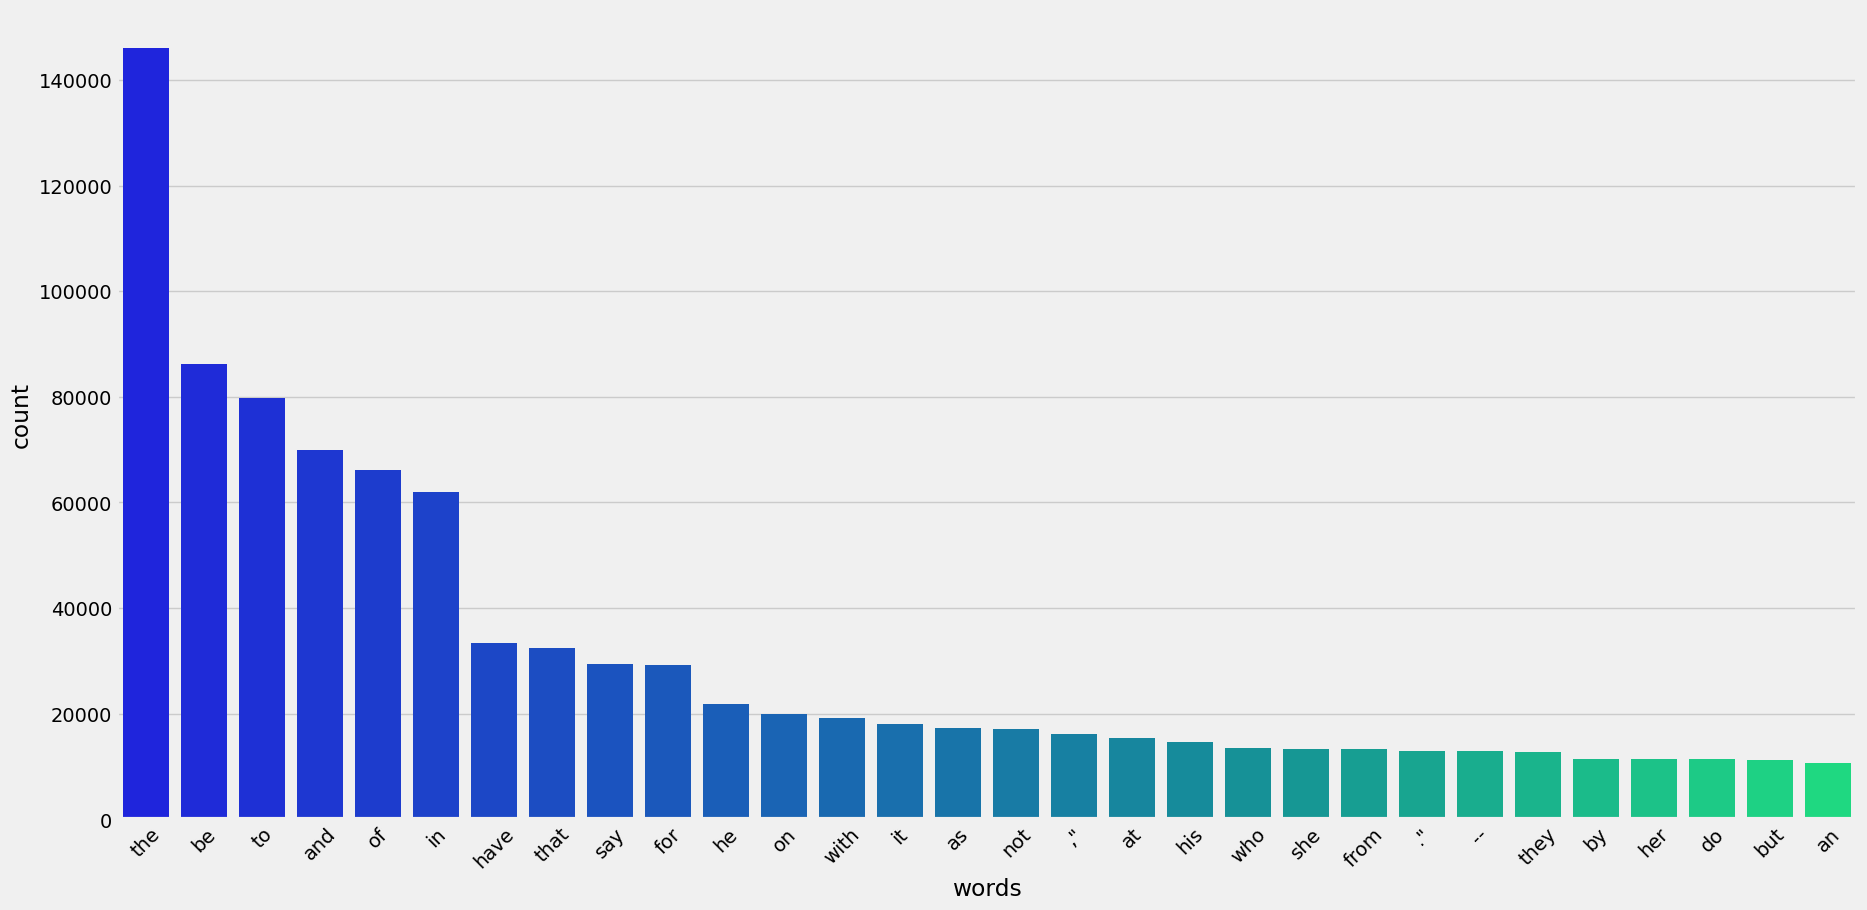

In [ ]:
#Joins text together
article_words = ','.join(list(articles['Full_Text_Clean'].values))

#Counts each word
Counter = Counter(article_words.split())
most_frequent = Counter.most_common(30) #looks at the top 30 words used

#Displaying graph
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

The above graph shows how many words are used across all of the articles and it does not tell us much useful information because it is picking up all of the stopwords, so more cleaning is needed

In [ ]:
#downloads list of stopwords
nltk.download('stopwords')

#a function that list stopwords, or words that we do not need to see meaning from the text
stopwords_list = stopwords.words('english')

#gets rid of some symbols that were being seen as words. Say is also being removed because it skews the topics at the end
stopwords_list.extend([',"', '."', '--', 'say'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Runs the Full_Text_List column through the function which holds the list of stopwords to remove
articles['Full_Text_List'] = [[word for word in line if word not in stopwords_list] for line in articles['Full_Text_List']]

In [ ]:
articles['Full_Text_Clean'] = list(map(to_string, articles['Full_Text_List']))

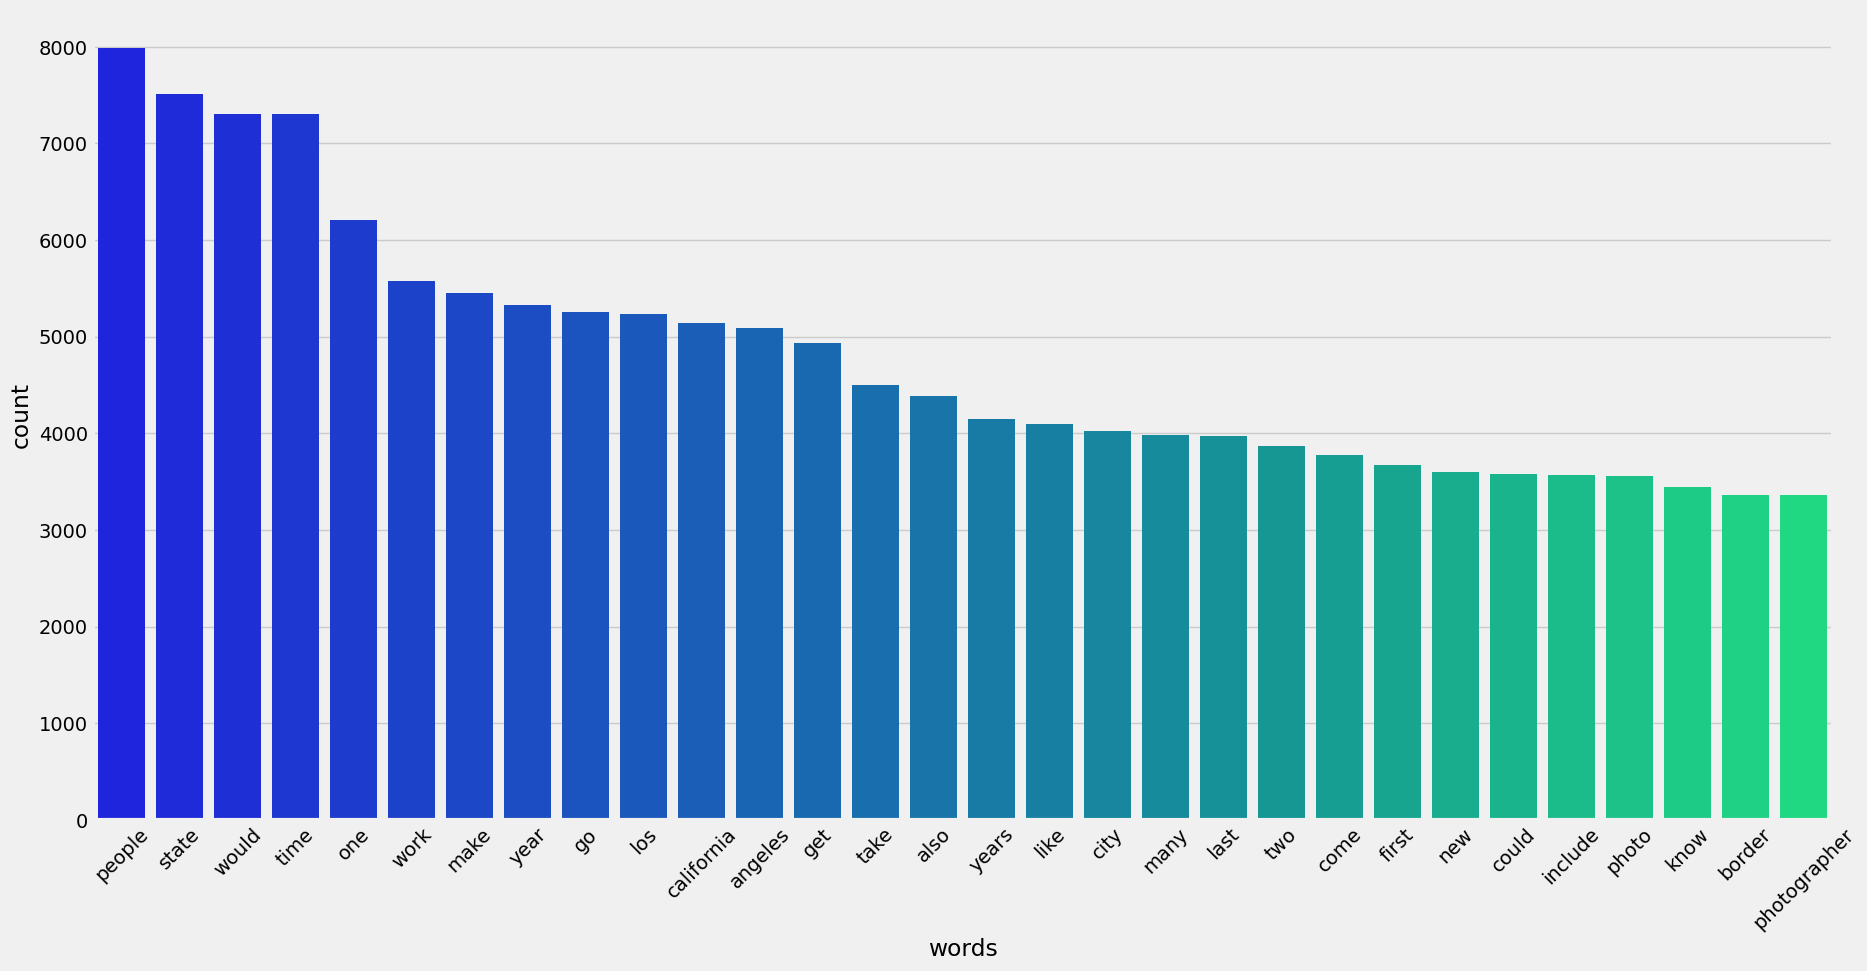

In [ ]:
from collections import Counter

#Displays new graph with words that convey more meaning

#Joins  text together
article_words = ','.join(list(articles['Full_Text_Clean'].values))

#Counts each word
Counter = Counter(article_words.split())
most_frequent = Counter.most_common(30)

#Bar plot of frequent words
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

Once the stop words have been removed, we can see above that the words have much more meaning that appear across the articles and are counted

Creating a word cloud to further visualize the data

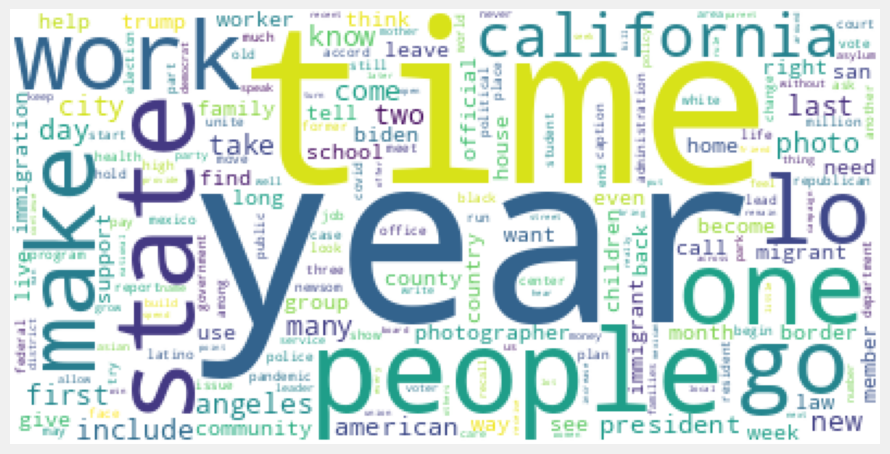

In [ ]:
#Generates the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(article_words)

#Visualizes the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

The word cloud is another way to visualize the bar graph above of the words without stopwords. It displays the same thing in a more fun way, but it doesn't show the exact numbers. It still does convey a similar message though.

Creating a bag-of-words

In [ ]:
#Creates Dictionary
id2word = gensim.corpora.Dictionary(articles['Full_Text_List'])

#Creates Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in articles['Full_Text_List']]

Determining number of topics discussed in the articles

<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

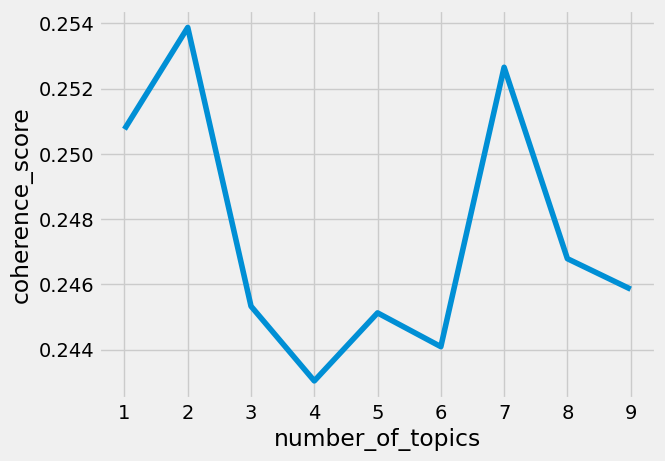

In [ ]:
from gensim.models import CoherenceModel

#Computes coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model,
                                       texts=articles['Full_Text_List'],
                                       dictionary=id2word,
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

#Creates a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

#Prints a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

The coherence score tells us which number of topics we should choose from the topics found across all of the articles from the algorithm. This is found by choosing the number of topics where there is a first peak in the line graph. Although 2 has the best coherence score, I chose 7 so we can see more topics and it still has a peak with a high score.

The next block of code will determine the topics with the words that follow each topic

In [ ]:
#Defines the number of topics
n_topics = 7

#Runs the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
#Prints the topics with their relavent words
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.037*"border" + 0.022*"migrants" + 0.020*"biden" + 0.017*"mexico" + 0.015*"administration" + 0.012*"asylum" + 0.012*"cross" + 0.011*"president" + 0.010*"patrol" + 0.009*"trump"
Topic: 1 Word: 0.087*"school" + 0.080*"students" + 0.027*"uc" + 0.027*"college" + 0.021*"youths" + 0.020*"student" + 0.017*"class" + 0.017*"parent" + 0.016*"ucla" + 0.016*"education"
Topic: 2 Word: 0.043*"police" + 0.020*"kill" + 0.020*"officer" + 0.018*"gun" + 0.014*"charge" + 0.013*"shoot" + 0.013*"crimes" + 0.011*"arrest" + 0.011*"crash" + 0.010*"victims"
Topic: 3 Word: 0.020*"state" + 0.018*"california" + 0.011*"would" + 0.009*"pandemic" + 0.008*"year" + 0.008*"bill" + 0.007*"house" + 0.007*"plan" + 0.006*"workers" + 0.006*"new"
Topic: 4 Word: 0.009*"time" + 0.009*"like" + 0.007*"one" + 0.007*"los" + 0.007*"go" + 0.007*"angeles" + 0.007*"work" + 0.006*"get" + 0.006*"people" + 0.006*"home"
Topic: 5 Word: 0.010*"asian" + 0.007*"vote" + 0.007*"president" + 0.006*"city" + 0.006*"american" + 0.006

The above results are the actual topics found in the articles and their associated words along with their weights. This is useful as we have now seen popular topics spread across all of the articles, which would be very difficult to do manually since there are so many documents. But surely there are more topics to be explored. Also it can be useful to name the topics ourselves, but it would also be nice to have the algorithm determine the topics for us. That is where BERTopic comes in. But first we can visualize these results with pyLDAVIS

To display pyLDAvis, I had to run this last in the code because of a conflict with a version pandas

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 43.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 

In [ ]:
!pip install pandas==1.5.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
#Imports and enables notebook to run visualization

import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model,
                                     corpus,
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.164692  0.017569       1        1  26.581236
4     -0.111642 -0.067010       2        1  26.411914
5     -0.122189 -0.033761       3        1  20.830364
3     -0.157263 -0.056588       4        1  15.927583
0     -0.074990  0.162393       5        1   6.848831
2      0.318929  0.227925       6        1   2.260828
1      0.311847 -0.250527       7        1   1.139245, topic_info=            Term         Freq        Total Category  logprob  loglift
454       school  2924.000000  2924.000000  Default  30.0000  30.0000
2351      border  3987.000000  3987.000000  Default  29.0000  29.0000
1375       state  7635.000000  7635.000000  Default  28.0000  28.0000
105   california  5234.000000  5234.000000  Default  27.0000  27.0000
1848      police  1766.000000  1766.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
72        attend   134.449387   539.664786   Topic7  -4.8915   3.0850
1401       teach   113.770269   387.027598   Topic7  -5.0585   3.2505
86      berkeley    95.667517   213.201485   Topic7  -5.2318   3.6734
873         fall   112.194046   782.563310   Topic7  -5.0725   2.5325
92         board    97.186142  1447.846424   Topic7  -5.2161   1.7736

[452 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
567       1  0.278310     000
567       2  0.093125     000
567       4  0.461717     000
567       5  0.167057     000
2185      1  0.998405      13
...     ...       ...     ...
560       1  0.208984   years
560       2  0.489546   years
560       3  0.150730   years
560       4  0.150730   years
8685      7  0.996445  youths

[778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 4, 1, 3, 2])

This graph gives us a better visual to work with from the data where we can further explore the found topics across the articles along with the words associated with it. But as we can see, we do not get a ton of information from this and further anaylsis is needed with topic modeling to gain more insights about the topics spread across the articles. But this is still nice to see how the topics overlap.

Now we will be moving on to BERTopic topic modeling for further topic analysis which will allow us to see more about the data with different visualizations

Followed along with these sources:

https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-topics-over-time

In [ ]:
#Installing the model
!pip install bertopic

In [ ]:
#Import statements for BERTopic
#Topic model
from bertopic import BERTopic
#Dimension reduction
from umap import UMAP

In [ ]:
#I am re-importing the data set since my original dataframe was manipulated so much
# Note that I am asking pandas to extract dates
new_df = pd.read_csv('https://www.dropbox.com/scl/fi/zx6kyd4euo537azrsuvv4/_articles.csv?rlkey=rex7xz7nzrpoz3tmdhblmpdu9&dl=1', parse_dates=['date']);

#adding this line of droping empty rows just in case they are null
new_df = new_df.dropna()

I am not going to reprint the dataframe since we already know what the original looks like

Using BERTopic processes the data in much of the same way as LDA but also slightly different. But this is useful to have a new perspective into the data.

In [ ]:
#Removes stopwords
stopwords = nltk.corpus.stopwords.words('english')
print(f'There are {len(stopwords)} default stopwords. They are {stopwords}')

There are 179 default stopwords. They are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'no

In [ ]:
# Remove stopwords
new_df['text_without_stopwords'] = new_df['fulltext'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in stopwords]))
# Lemmatization
new_df['text_lemmatized'] = new_df['text_without_stopwords'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stopwords]))
# Take a look at the data
new_df.head()

,Number,id,title,pub,author,date,year,url,fulltext,Date,New,text_without_stopwords,text_lemmatized
0,0,2859437733,Get into Caltech without calculus? It could happen; The campus is changing admission requirements to help underserved students.,Los Angeles Times,"Watanabe, Teresa.",2023-09-01,2023,https://www.proquest.com/docview/2859437733/fulltext/60404B98B51C40A4PQ/2072?accountid=4485,"Get into Caltech without calculus? It could happen; The campus is changing admission requirements to help underserved students.\n\nCorrection: Caltech admissions: In the Sept. 1 Section A, the headline on an article about Caltech offering alternatives to high school applicants without access to calculus, chemistry and physics courses might have given the impression that applicants would not need proficiency in the subject. Caltech is offering alternative ways for students to demonstrate their knowledge in those fields.\nKimberly Miranda is the brainy daughter of Guatemalan immigrants and the first in her family to attend college. But she almost didn't make it to the California Institute of Technology.\nHer school in Redwood City, Calif., didn't offer algebra in eighth grade, which threw her off the progression of high school math classes leading to calculus -- a long-standing Caltech admission requirement. Miranda managed to double up on math courses in sophomore year to reach calculus as a senior, but not all students have the wherewithal -- or support -- to take that path.\nAnd scores of students don't even have that chance, because more than one-third of the nation's high schools don't offer calculus, and many also lack physics and chemistry classes, two other Caltech admission requirements. For years, the institute, a global powerhouse of science, technology, engineering and math education, fielded hundreds of calls each year from distraught students and parents about...",2023-09-01,20230901,"Get Caltech without calculus? could happen; campus changing admission requirements help underserved students. Correction: Caltech admissions: Sept. 1 Section A, headline article Caltech offering alternatives high school applicants without access calculus, chemistry physics courses might given impression applicants would need proficiency subject. Caltech offering alternative ways students demonstrate knowledge fields. Kimberly Miranda brainy daughter Guatemalan immigrants first family attend college. almost make California Institute Technology. school Redwood City, Calif., offer algebra eighth grade, threw progression high school math classes leading calculus -- long-standing Caltech admission requirement. Miranda managed double math courses sophomore year reach calculus senior, students wherewithal -- support -- take path. scores students even chance, one-third nation's high schools offer calculus, many also lack physics chemistry classes, two Caltech admission requirements. years, institute, global powerhouse science, technology, engineering math education, fielded hundreds calls year distraught students parents issue. Caltech held firm, making exceptions, even ""absolutely astounding"" applicants, one faculty member put it. Caltech, name equity, shifting gears. groundbreaking step, campus announced Thursday drop admission requirements calculus, physics chemistry courses students access offer alternative paths prove mastery material. ""Brilliant students exist every single ...","Get Caltech without calculus? could happen; campus changing admission requirement help underserved students. Correction: Caltech admissions: Sept. 1 Section A, headline article Caltech offering alternative high school applicant without access calculus, chemistry physic course might given impression applicant would need proficiency subject. Caltech offering alternative way student demonstrate knowledge fields. Kimberly Miranda brainy daughter Guatemalan immigrant first family attend college. almost make California Institute Technology. school Redwood City, Calif., offer algebra 

It adds the new columns to the end of the dataframe. As you can see, it looks quite similar to how LDA processed the data.

In [ ]:
#Initiates UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
#Initiates BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
#Runs BERTopic model
topics, probabilities = topic_model.fit_transform(new_df['text_lemmatized'])

In [ ]:
#Gets the list of topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,448,-1_said_one_people_city,"[said, one, people, city, los, angeles, would, year, like, times]","[Defying law politics stop overdose deaths; Illegal pop-up leader save life Isaias Lopez dying, know it. Lopez slumped wall Tenderloin district San Francisco, concentration homelessness drug use divided city politically. baby-blue baseball cap white hoodie covered head, making another human lump avoided passersby. begun nod fentanyl minute ago scrap tin foil lay nearly empty legs. Lopez's oxygen saturation level fallen 87%, according thumb monitor aid worker illegally run safe consumption site nearby slipped him; danger passing never waking up. roused best could, put oxygen mask him, likely saving life. Minutes earlier, stood le block away man I'll call E. almost died, also due fentanyl overdose. E. behind concrete barrier sidewalk, breathing stopped heart still beating. aid workers, illegal overdose prevention operation, rubbed chest. oxygen mask went on. Two dos Narcan later, walking away. ""Just another day around here,"" said E.'s friend Jabari M., run get Narcan realized happening. asked use full name stigma streets. Two life saved lunch -- rogue activist breaking law it. ""Saving life act civil disobedience,"" Lydia Bransten, one illicit do-gooders, told me. ""Insane."" city 470 people already died overdoses year, putting 2023 track becoming deadly year drug death record, disagree. Keeping overdose prevention site illegal insane, would imply lack control situation. cruel, addicted care -- move put optic politics lives. that's political decision made President Biden, secon..."
1,0,246,0_border_migrant_asylum_us,"[border, migrant, asylum, us, immigration, said, administration, mexico, biden, policy]","[limbo border; four year chaos, policy shift Biden. now, uncertainty reigns. morning sunlight streamed undisturbed concrete expanse known El Chaparral, one busiest border crossing world, day inauguration President Biden. people hovered around silent turnstile marked official entry northern Mexico Southern California -- possible pathway long-awaited exit Trump era. Suddenly gate opened, Gabi husband rushed extend temporary residency visa Mexican government. three kid fled El Salvador 2019 nephew killed refusing join gang. asked U.S. asylum. Instead, official forced back border Trump policy known ""Remain Mexico."" last court hearing set March 2020, Trump administration indefinitely closed border, citing COVID-19. set March 2021. ""I afraid Trump,"" said Gabi, asked use first name safety. ""That's waited, seeking asylum here, wanted legally. ""With Biden, think light darkness,"" Gabi went on. ""We hope he'll let u fight asylum inside, safe place children. want stop running."" quiet El Chaparral belied chaos former President Trump's policy wrought across roughly 2,000-mile U.S.-Mexico border last four year -- already dangerous uncertainty Biden's plan deal it. California's border Mexico is, many ways, Trump transformed policy jingoistic bluster 2016 campaign announcement, condemned migrant rapist drug dealers. Here, Trump deployed Border Patrol agent U.S. troop ahead 2018 midterms. Here, along border, estimated 5,000 family torn apart, El Chaparral, Trump's administration launched Re..."
2,1,102,1_asian_chinese_korean_said,"[asian, chinese, korean, said, hate, americans, american, china, people, year]","[Leaving Asia Fargo; North Dakota fastest-growing Asian American population U.S. unexpected twist led Rev. Yuanlai Zhang - minister lived among 13 million others hot humid Chinese city Shenzhen - start new life sparse frigid prairie North Dakota. Zhang become man plains. Mandarin-language preacher travel state Bible pressed suit, life wife toddler suburban Fargo. He's first full-time pastor Red River Valley Chinese Christian Church, founded five year ago whose 50-family congregation largest Chinese Christian flock North Dakota. ""We knew New York, Texas California China,"" said

As you can see, the BERTopic model gives us much more information about our data than the LDA model did. We have many more topics along with those topics named by the algorithm and the associated documents. It also counts how many times those topics were found among the documents, which is a great insight to know. We can further visualize this abundance of new data with the model as well.

In [ ]:
#Visualizes top topic keywords for the first 12 topics
topic_model.visualize_barchart(top_n_topics=12)

This outputs the first 12 topics along with the words and their associated scores for how much those words relate to the topics that were found across the articles

In [ ]:
#Visualizes term rank decrease
topic_model.visualize_term_rank()

According to ChatGPT, this shows "Each term (word or phrase) in a topic is assigned a score based on its relevance or importance to that topic. This score reflects how well the term represents the topic's content. Terms with higher scores are more closely associated with the topic...The term score decline per topic measures how much the term's importance decreases as you move from the most relevant topic to less relevant topics. In other words, it quantifies how specific or discriminative a term is for a particular topic." This is not useful for our demonstration, but it shows another visual that can be used within this model that could prove to be useful in another situation.

In [ ]:
#Visualizes intertopic distance
topic_model.visualize_topics()

Just like the pyLDAvis visual, this is a similar visual which shows how topics overlap and how far or close to one another they are. With the new found number of topics, this proves to be quite useful to see how similar many of the topics are throughout the articles

In [ ]:
#Visualizes connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=15)

This is another way to show how the topics relate to one another, but only for the first 15 topics. This allows us to visualize how the topics relate to one another and how many of the topics fit into another topic which builds the hierarchy we see

In [ ]:
#Visualizes similarity using heatmap
topic_model.visualize_heatmap()

The heatmap visual takes all of the topics (even though the even ones are displayed) and displays it in a way where we can compare how similar topics are.For example, we can see that Topic 0 (X axis) and Topic 39 (Y axis) have a high similarity score. This is a very useful visual as it allows us to see how all of the topics relate to one another in a simple way that is visually appealing.

In [ ]:
#sets new variables
text = new_df['text_lemmatized'].to_list()
time = new_df['date'].to_list()

In [ ]:
#Creates topics over time
model = BERTopic(verbose=True)
topics, probs = model.fit_transform(text)
topics_over_time = model.topics_over_time(text, time)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2023-10-08 16:17:53,987 - BERTopic - Transformed documents to Embeddings
2023-10-08 16:18:00,712 - BERTopic - Reduced dimensionality
2023-10-08 16:18:00,762 - BERTopic - Clustered reduced embeddings
846it [01:02, 13.58it/s]


In [ ]:
#Displays the visual
model.visualize_topics_over_time(topics_over_time, topics=[2, 10, 15, 20, 25, 30, 35])

This is an extremely useful visualization that allows us to see when the topics were written about over time throughout the dataset. I only put a few random topics in, but if I wanted to further explore certain topics the model found this could be a useful way to see when they were written about. One complaint I have is that the frequency should start at 0 and not 1 which makes the graph a bit confusing and not look as well as it could. This is a complaint I will get into later about BERTopic.  

As you can see, LDA and BERTopic provide relatively easy ways to gain a lot of valuable insight into the data through visualizations. BERTopic provides many more end result visualizations though that let us really examine the data, but it lacks the customization that LDA has.

# Conclusion/Summary

Both models allowed us to gain valuable insights into the topics of the texts relatively easily and quickly. LDA requires a bit more programming knowledge but allows us to have more customization of the visuals which is useful since many visuals can be easily skewed. BERTopic is much easier to use but has a black box nature with little customization options right out of the box. BERTopic also gives us much more detailed visuals with more topics and more detail about those topics but is much more resource intensive. This could be a useful tool to use for undergraduate students who wish to manually code this dataset as this would allow them to understand the hidden topics among the data much quicker and allow them to do more with the data with very little prior programming knowledge. Meanwhile, LDA only has a couple visuals that do not substantially examine the data and it does not find as many topics as BERTopic. The main limitation is that for both models when it comes to using visuals that are predetermined, we have little agency in editing the visuals and some of the visuals have issues that could be fixed to display better results. But, even with those, using both methods allows students to do a deep dive into the topics of the text relatively quickly and allows them to visualize it in a way manually coding could not.  

# Reflection

When I first started the project, I just knew I wanted to explore the topics that could be found in the text. I knew other students would be manually coding, so I was interested to see what topic modeling could find for them to use or compare their results with. This did not have a lot of substance for visuals though when I was just using LDA at first. It only had a couple of useful visuals, and it still did not give a ton of information on the dataset. I wanted to include how the topics over time with the topics found through LDA. This is where I encountered a host of issues. This is most likely possible but was a technical barrier for me as I do not have the programming or math skills to do this myself. After a lot of trial and error, along with a lot of searching on Google and asking ChaptGPT questions, I eventually stumbled upon BERTopic. After some trial and error, I was able to get it working and I was shocked by how powerful it is. I was able to get so much more out of this topic modeling vs LDA which made me want to show the differences between the two along with how different their visualizations can be. This allowed me to do a deep dive into the topics of the data while also showcasing how they work and what their strengths and weaknesses are. I am happy with how it turned out along with the visualizations I was able to produce through them about the dataset.  